In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

from keras.preprocessing.sequence import make_sampling_table, skipgrams
from keras.preprocessing.text import Tokenizer

from matplotlib import pyplot as plt
import numpy as np

from collections import Counter
from keras.utils import pad_sequences
import os, re, csv, math, codecs

from keras.layers import Bidirectional, LSTM, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda,Flatten,Activation,Reshape, BatchNormalization
import keras.backend as K
from keras.activations import softmax
from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Reshape, Permute
from keras.callbacks import ReduceLROnPlateau

In [ ]:
TNG_train = fetch_20newsgroups(subset="train")

# Cálculo de matriz

In [ ]:
max_words=30000
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)
tokenizer.fit_on_texts(TNG_train.data)
seqs=tokenizer.texts_to_sequences(TNG_train.data)
print (len(seqs))
print(seqs[0])

11314
[15, 1, 4309, 1351, 16, 11127, 39, 251, 30, 43, 299, 10, 18, 96, 79, 92, 23734, 4309, 1351, 16, 35, 78, 4, 2953, 611, 1768, 33, 212, 9, 27, 1309, 28, 172, 67, 48, 124, 9880, 64, 17, 18, 299, 9, 709, 2, 87, 264, 12, 27, 5, 37, 1498, 2267, 299, 1163, 3, 19, 15, 2, 1348, 13638, 844, 15449, 12, 27, 338, 5, 1, 2, 4018, 81, 183, 485, 8, 1377, 2, 845, 8165, 27, 1836, 15, 2, 817, 4, 2, 727, 18, 10, 45, 9, 89, 28, 172, 40, 1, 5, 829, 274, 1079, 2909, 199, 4, 2805, 154, 18, 299, 10, 240, 629, 26, 809, 358, 14, 22, 17, 18, 21901, 385, 299, 182, 113, 189, 207, 1499, 1342, 3, 14, 36, 59, 7861, 1]


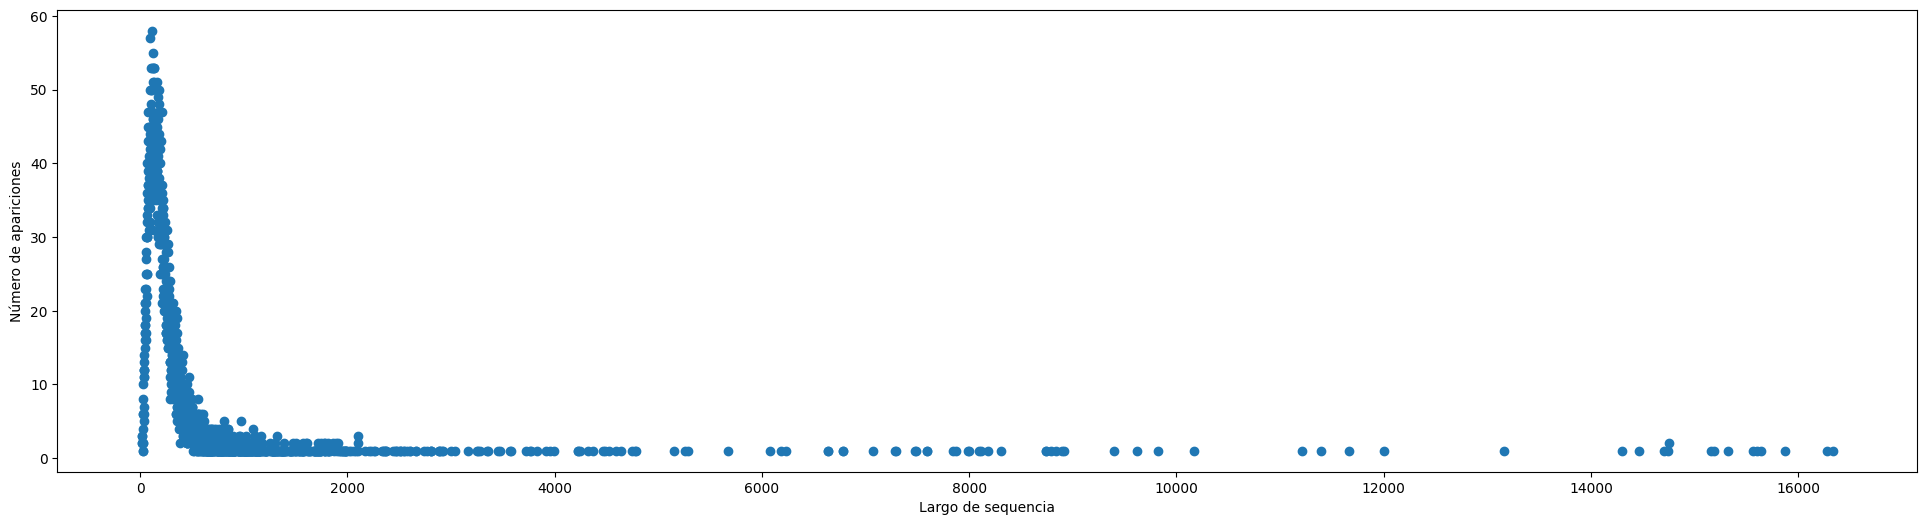

In [ ]:
lengths=[len(seq) for seq in seqs]
lengths=dict(Counter(lengths))
plt.figure(figsize=[24,6])
plt.scatter(list(lengths.keys()), list(lengths.values()))
plt.xlabel("Largo de sequencia")
plt.ylabel("Número de apariciones")
#plt.ylim(0,100)
plt.show()

La mayoría de las secuencias tiene un largo menor a 2000, por lo tanto se toma este valor como el máximo posible.

In [ ]:
max_len = 2000
pad_seqs = pad_sequences(seqs, maxlen=max_len)

reverse_dictionary = tokenizer.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])

In [ ]:
subset = {key: value for key, value in dictionary.items() if value < 100}
subset

{'UNK': 1,
 'the': 2,
 'to': 3,
 'of': 4,
 'a': 5,
 "'ax": 6,
 'and': 7,
 'in': 8,
 'i': 9,
 'is': 10,
 'that': 11,
 'it': 12,
 'for': 13,
 'you': 14,
 'from': 15,
 'edu': 16,
 'on': 17,
 'this': 18,
 'be': 19,
 'are': 20,
 'not': 21,
 'have': 22,
 'with': 23,
 'as': 24,
 '1': 25,
 'or': 26,
 'was': 27,
 'if': 28,
 'but': 29,
 'subject': 30,
 'they': 31,
 'com': 32,
 'lines': 33,
 'at': 34,
 'organization': 35,
 'by': 36,
 '2': 37,
 'an': 38,
 'my': 39,
 'can': 40,
 'x': 41,
 '3': 42,
 'what': 43,
 '0': 44,
 'all': 45,
 'will': 46,
 'm': 47,
 'there': 48,
 'would': 49,
 'one': 50,
 'do': 51,
 "'": 52,
 'about': 53,
 're': 54,
 'we': 55,
 'writes': 56,
 'so': 57,
 'he': 58,
 'your': 59,
 'no': 60,
 'has': 61,
 'article': 62,
 'any': 63,
 'me': 64,
 'some': 65,
 'who': 66,
 'out': 67,
 'which': 68,
 '4': 69,
 'q': 70,
 'more': 71,
 'like': 72,
 'people': 73,
 "don't": 74,
 'when': 75,
 '5': 76,
 'just': 77,
 'university': 78,
 'posting': 79,
 'their': 80,
 'were': 81,
 'up': 82,
 'r': 83

# Fasttext word vectors

Utilizaremos este modelo pre entrenado.

In [ ]:
# Downloading fasttext word vectors
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip
!ls

--2023-09-17 01:54:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.114, 52.84.251.27, 52.84.251.106, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   175MB/s    in 3.7s    

2023-09-17 01:54:50 (175 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   
sample_data  wiki-news-300d-1M.vec  wiki-news-300d-1M.vec.zip


In [ ]:
#load embeddings
EMBEDDING_DIR = "/content/"
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_DIR+'wiki-news-300d-1M.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 999995 word vectors


In [ ]:
embed_dim=300
num_words=len(dictionary)+1
embedding_matrix=np.zeros([num_words,embed_dim])
for word, idx in dictionary.items():
  if idx <= num_words and word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

# Modelo Básico

Tomaremos este modelo como base para el resto, para ver el mínimo de rendimiento esperado para los siguientes modelos que serán más complejos.

In [ ]:
nb_words=num_words
num_filters=64
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Lambda(lambda x: K.sum(x, axis=1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         40243200  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
Total params: 40253492 (153.55 MB)
Trainable params: 10292 (40.20 KB)
Non-trainable params: 40243200 (153.52 MB)
_________________________________________________________________


In [ ]:
model.fit(pad_seqs, TNG_train.target, batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
283/283 [==============================] - 2s 6ms/step - loss: 1.0217 - accuracy: 0.6755 - val_loss: 1.1009 - val_accuracy: 0.6589
Epoch 2/15
283/283 [==============================] - 1s 5ms/step - loss: 0.9730 - accuracy: 0.6906 - val_loss: 1.2030 - val_accuracy: 0.6293
Epoch 3/15
283/283 [==============================] - 2s 6ms/step - loss: 1.0012 - accuracy: 0.6859 - val_loss: 1.0934 - val_accuracy: 0.6615
Epoch 4/15
283/283 [==============================] - 2s 7ms/step - loss: 0.9734 - accuracy: 0.6977 - val_loss: 1.1636 - val_accuracy: 0.6350
Epoch 5/15
283/283 [==============================] - 2s 6ms/step - loss: 0.9435 - accuracy: 0.7026 - val_loss: 1.0377 - val_accuracy: 0.6814
Epoch 6/15
283/283 [==============================] - 2s 6ms/step - loss: 0.9324 - accuracy: 0.7026 - val_loss: 1.0874 - val_accuracy: 0.6659
Epoch 7/15
283/283 [==============================] - 2s 7ms/step - loss: 0.9323 - accuracy: 0.7099 - val_loss: 1.0790 - val_accuracy: 0.6602
Epoch 

Se puede observar que el accuracy de validación llega hasta 0.68 (y sin haber realizado un ajuste de hiperparámetros), por lo que se espera que el accuracy de los siguientes modelos con attention sean, al menos, mejor.

# Obtención del mejor modelo

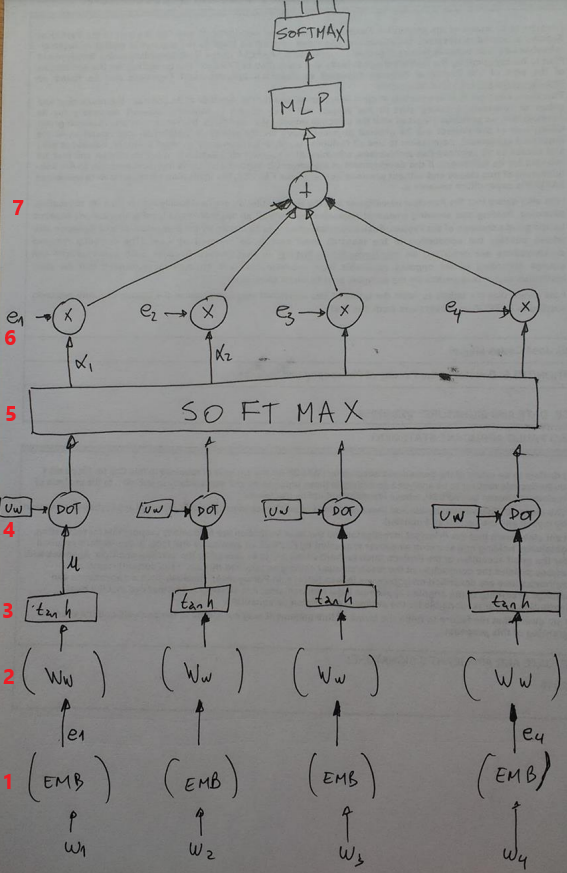

Se separará al código en las secciones indicadas en la imagen (1,2,3,4,5,6,7). Cada una de las secciones indica un paso a seguir en el proceso de attention. En los diferentes modelos éstos se iran complejizando, en búsqueda de un mayor accuracy de validación.

In [ ]:
def softMaxOverTime(x):
    return softmax(x,axis=1)

key_dim=50
nb_words=num_words
num_filters=64

## a) MLP + Embeddings + Attention

In [ ]:
# 1
input_layer = Input(shape=(max_len,))

# 2
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

# 3
dense_input=Dense(key_dim,activation="tanh")(embedding_layer)

# 4
ulog_attention=Dense(1,activation="linear")(dense_input)

# 5
attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(embed_dim))(attention)
repeated_attention=Reshape([max_len,embed_dim])(repeated_attention)
# 6
weighted_embeddings=Multiply()([repeated_attention,embedding_layer])

# 7
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

#Dense
dense1=Dense(32, activation='relu')(embedding_sum)
output_layer =Dense(20, activation='softmax')(dense1)

model = Model(input_layer, output_layer)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2000)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 2000, 300)            4024320   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 dense_5 (Dense)             (None, 2000, 50)             15050     ['embedding_2[0][0]']         
                                                                                                  
 dense_6 (Dense)             (None, 2000, 1)              51        ['dense_5[0][0]']       

In [ ]:
model.fit(pad_seqs, TNG_train.target,batch_size=32,epochs=15,validation_split=0.2)

Epoch 1/15
283/283 [==============================] - 7s 13ms/step - loss: 2.2648 - accuracy: 0.3598 - val_loss: 1.4677 - val_accuracy: 0.6058
Epoch 2/15
283/283 [==============================] - 3s 12ms/step - loss: 1.2556 - accuracy: 0.6513 - val_loss: 1.1570 - val_accuracy: 0.6664
Epoch 3/15
283/283 [==============================] - 3s 12ms/step - loss: 1.0523 - accuracy: 0.7020 - val_loss: 1.0183 - val_accuracy: 0.7066
Epoch 4/15
283/283 [==============================] - 3s 12ms/step - loss: 0.9344 - accuracy: 0.7307 - val_loss: 0.9393 - val_accuracy: 0.7265
Epoch 5/15
283/283 [==============================] - 3s 11ms/step - loss: 0.8596 - accuracy: 0.7516 - val_loss: 0.8912 - val_accuracy: 0.7371
Epoch 6/15
283/283 [==============================] - 4s 13ms/step - loss: 0.8085 - accuracy: 0.7660 - val_loss: 0.8600 - val_accuracy: 0.7525
Epoch 7/15
283/283 [==============================] - 4s 15ms/step - loss: 0.7672 - accuracy: 0.7758 - val_loss: 0.8280 - val_accuracy: 0.7543

Se puede apreciar que el accuracy de validation llegó a 0.79, lo cual se considera una mejora significativa frente a los 0.68 previamente analizados

## b) MLP + Embeddings + Attention + CNN

In [ ]:
# 1
input_layer = Input(shape=(max_len,))

# 2
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

# CNN
cnn_output = Conv1D(num_filters, 8, activation='relu', padding='same')(embedding_layer)

# 3
dense_input = Conv1D(num_filters, 8, activation="tanh", padding="same")(cnn_output)

# 4
ulog_attention = Dense(1, activation="linear")(dense_input)

# 5
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(num_filters))(attention)
repeated_attention=Reshape([max_len,num_filters])(repeated_attention)

# 6
weighted_embeddings = Multiply()([attention, embedding_layer])

# 7
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

# Dense
dense1 = Dense(32, activation='relu')(embedding_sum)
output_layer = Dense(20, activation='softmax')(dense1)

model = Model(input_layer, output_layer)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2000)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 2000, 300)            4024320   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_2 (Conv1D)           (None, 2000, 64)             153664    ['embedding_3[0][0]']         
                                                                                                  
 conv1d_3 (Conv1D)           (None, 2000, 64)             32832     ['conv1d_2[0][0]']      

In [ ]:
model.fit(pad_seqs, TNG_train.target,batch_size=32,epochs=15,validation_split=0.2)

Epoch 1/15
283/283 [==============================] - 12s 34ms/step - loss: 2.3817 - accuracy: 0.3132 - val_loss: 1.5035 - val_accuracy: 0.6266
Epoch 2/15
283/283 [==============================] - 9s 33ms/step - loss: 1.1415 - accuracy: 0.6884 - val_loss: 0.9891 - val_accuracy: 0.7238
Epoch 3/15
283/283 [==============================] - 9s 31ms/step - loss: 0.8190 - accuracy: 0.7651 - val_loss: 0.8375 - val_accuracy: 0.7446
Epoch 4/15
283/283 [==============================] - 9s 31ms/step - loss: 0.6433 - accuracy: 0.8044 - val_loss: 0.7845 - val_accuracy: 0.7676
Epoch 5/15
283/283 [==============================] - 9s 33ms/step - loss: 0.5279 - accuracy: 0.8398 - val_loss: 0.7636 - val_accuracy: 0.7782
Epoch 6/15
283/283 [==============================] - 9s 32ms/step - loss: 0.4404 - accuracy: 0.8641 - val_loss: 0.7495 - val_accuracy: 0.7839
Epoch 7/15
283/283 [==============================] - 9s 31ms/step - loss: 0.3932 - accuracy: 0.8775 - val_loss: 0.7584 - val_accuracy: 0.783

Se puede apreciar una leve mejora respecto al modelo anterior. Sin embargo, no es del todo significativa.

## c) MLP + Embeddings + Attention + TextCNN

In [ ]:
from keras.src.layers.normalization import batch_normalization
#1
input_layer = Input(shape=(max_len,))

#2
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

#3
dense_input=Dense(key_dim,activation="tanh")(embedding_layer)

#4
ulog_attention=Dense(1,activation="linear")(dense_input)

#5
attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(embed_dim))(attention)
repeated_attention=Reshape([max_len,embed_dim])(repeated_attention)

#6
weighted_embeddings=Multiply()([repeated_attention,embedding_layer])

#7
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

# TextCNN
conv4 = Conv1D(num_filters, 4, activation='relu', padding='same')(embedding_layer)
conv3 = Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
conv2 = Conv1D(num_filters, 2, activation='relu', padding='same')(embedding_layer)
pool4 = GlobalMaxPooling1D()(conv4)
pool3 = GlobalMaxPooling1D()(conv3)
pool2 = GlobalMaxPooling1D()(conv2)
cnn_output = Concatenate()([pool4, pool3, pool2])

# Combine
combined = Concatenate()([embedding_sum, cnn_output])

# Dense
dense1 = Dense(32, activation='relu')(combined)
output_layer = Dense(20, activation='softmax')(dense1)

model = Model(input_layer, output_layer)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 2000)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 2000, 300)            4024320   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 dense_12 (Dense)            (None, 2000, 50)             15050     ['embedding_4[0][0]']         
                                                                                                  
 dense_13 (Dense)            (None, 2000, 1)              51        ['dense_12[0][0]']      

In [ ]:
model.fit(pad_seqs, TNG_train.target,batch_size=32,epochs=15,validation_split=0.2)

Epoch 1/15
283/283 [==============================] - 17s 49ms/step - loss: 2.3995 - accuracy: 0.2686 - val_loss: 1.3714 - val_accuracy: 0.6350
Epoch 2/15
283/283 [==============================] - 12s 41ms/step - loss: 0.8988 - accuracy: 0.7654 - val_loss: 0.7792 - val_accuracy: 0.7539
Epoch 3/15
283/283 [==============================] - 12s 42ms/step - loss: 0.5023 - accuracy: 0.8652 - val_loss: 0.5828 - val_accuracy: 0.8316
Epoch 4/15
283/283 [==============================] - 12s 41ms/step - loss: 0.3163 - accuracy: 0.9214 - val_loss: 0.5318 - val_accuracy: 0.8475
Epoch 5/15
283/283 [==============================] - 12s 43ms/step - loss: 0.1924 - accuracy: 0.9617 - val_loss: 0.4728 - val_accuracy: 0.8692
Epoch 6/15
283/283 [==============================] - 12s 41ms/step - loss: 0.1130 - accuracy: 0.9844 - val_loss: 0.4588 - val_accuracy: 0.8630
Epoch 7/15
283/283 [==============================] - 12s 42ms/step - loss: 0.0638 - accuracy: 0.9950 - val_loss: 0.4494 - val_accuracy:

Al utilizar TextCNN el accuracy de validación mejora en gran medida, por lo que se determinó que para intentar alcanzar el mejor modelo, éste debería estar presente.

## d) MLP + Embeddings + Attention + CNN + TextCNN

In [ ]:
# 1
input_layer = Input(shape=(max_len,))

# 2
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

# CNN
cnn_output = Conv1D(num_filters, 8, activation='relu', padding='same')(embedding_layer)

# 3
dense_input = Conv1D(num_filters, 8, activation="tanh", padding="same")(cnn_output)

# 4
ulog_attention = Dense(1, activation="linear")(dense_input)

#5
attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(embed_dim))(attention)
repeated_attention=Reshape([max_len,embed_dim])(repeated_attention)

#6
weighted_embeddings=Multiply()([repeated_attention,embedding_layer])

#7
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

# TextCNN
conv4 = Conv1D(num_filters, 4, activation='relu', padding='same')(embedding_layer)
conv3 = Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
conv2 = Conv1D(num_filters, 2, activation='relu', padding='same')(embedding_layer)
pool4 = GlobalMaxPooling1D()(conv4)
pool3 = GlobalMaxPooling1D()(conv3)
pool2 = GlobalMaxPooling1D()(conv2)
cnn_output = Concatenate()([pool4, pool3, pool2])

# Combine
combined = Concatenate()([embedding_sum, cnn_output])

# Dense
dense1 = Dense(32, activation='relu')(combined)
output_layer = Dense(20, activation='softmax')(dense1)

model = Model(input_layer, output_layer)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2000)]               0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 2000, 300)            4024320   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_7 (Conv1D)           (None, 2000, 64)             153664    ['embedding_5[0][0]']         
                                                                                                  
 conv1d_8 (Conv1D)           (None, 2000, 64)             32832     ['conv1d_7[0][0]']      

In [ ]:
model.fit(pad_seqs, TNG_train.target,batch_size=32,epochs=15,validation_split=0.2)

Epoch 1/15
283/283 [==============================] - 22s 67ms/step - loss: 2.2090 - accuracy: 0.3812 - val_loss: 1.2083 - val_accuracy: 0.6650
Epoch 2/15
283/283 [==============================] - 19s 66ms/step - loss: 0.8443 - accuracy: 0.7663 - val_loss: 0.7153 - val_accuracy: 0.7932
Epoch 3/15
283/283 [==============================] - 17s 61ms/step - loss: 0.4804 - accuracy: 0.8672 - val_loss: 0.5501 - val_accuracy: 0.8347
Epoch 4/15
283/283 [==============================] - 18s 65ms/step - loss: 0.3002 - accuracy: 0.9185 - val_loss: 0.4956 - val_accuracy: 0.8529
Epoch 5/15
283/283 [==============================] - 17s 61ms/step - loss: 0.1848 - accuracy: 0.9616 - val_loss: 0.4925 - val_accuracy: 0.8489
Epoch 6/15
283/283 [==============================] - 18s 65ms/step - loss: 0.1075 - accuracy: 0.9860 - val_loss: 0.4566 - val_accuracy: 0.8595
Epoch 7/15
283/283 [==============================] - 17s 61ms/step - loss: 0.0612 - accuracy: 0.9951 - val_loss: 0.4433 - val_accuracy:

Este último modelo es aquel con el cual se obtuvo mayor accuracy de validación, combinando la parte de attention, con TextCNN. Sin embargo, se puede mejorar aún más variando sus hiperparámetros para poder hallar una convergencia mas óptima y tratar de evitar los problemas actuales de overfitting sin disminuir en gran medida el acurracy de validación.

# Ajustes de hiperparámetros

Se fueron modificando diversos hiperparámentros, de uno a la vez, hasta hallar el mejor modelo. A su vez tambien se agregó:


*   Batch normalization.
*   Drop out.
*   Reducción de accuracy en plateau.



In [ ]:
def best_model (learning_rate = 0.001, batch_size= 8, epochs=20, dropout_rate = 0.1, batch_normalization = False,
                num_filters = 64, k_size = 8, nb_words = num_words, embed_dim = embed_dim,
                embedding_matrix = embedding_matrix, max_len = max_len, verbose = True):
    # 1
    input_layer = Input(shape=(max_len,))

    # 2
    embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

    # CNN
    cnn_output = Conv1D(num_filters, k_size, activation='relu', padding='same')(embedding_layer)

    # 3
    dense_input = Conv1D(num_filters, k_size, activation="tanh", padding="same")(cnn_output)

    # 4
    ulog_attention = Dense(1, activation="linear")(dense_input)

    #5
    attention=Activation(softMaxOverTime)(ulog_attention)
    repeated_attention=TimeDistributed(RepeatVector(embed_dim))(attention)
    repeated_attention=Reshape([max_len,embed_dim])(repeated_attention)

    #6
    weighted_embeddings=Multiply()([repeated_attention,embedding_layer])

    #7
    embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

    # TextCNN
    conv4 = Conv1D(num_filters, 4, activation='relu', padding='same')(embedding_layer)
    if (batch_normalization): conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    pool4 = GlobalMaxPooling1D()(conv4)

    conv3 = Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
    if (batch_normalization): conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    pool3 = GlobalMaxPooling1D()(conv3)

    conv2 = Conv1D(num_filters, 2, activation='relu', padding='same')(embedding_layer)
    if (batch_normalization): conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    pool2 = GlobalMaxPooling1D()(conv2)

    cnn_output = Concatenate()([pool4, pool3, pool2])

    # Combine
    combined = Concatenate()([embedding_sum, cnn_output])

    # Dense
    dense1 = Dense(32, activation='relu')(combined)
    output_layer = Dense(20, activation='softmax')(dense1)

    model = Model(input_layer, output_layer)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                patience=2, min_lr=1e-8, min_delta=0.001)

    adam = optimizers.Adam(learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    history = model.fit(pad_seqs, TNG_train.target,batch_size=batch_size,epochs=epochs,validation_split=0.2, callbacks = [reduce_lr], verbose = verbose)

    return history

In [ ]:
history = best_model()

Epoch 1/20
1132/1132 [==============================] - 28s 21ms/step - loss: 1.5055 - accuracy: 0.5649 - val_loss: 0.7717 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 2/20
1132/1132 [==============================] - 23s 20ms/step - loss: 0.4991 - accuracy: 0.8515 - val_loss: 0.5306 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 3/20
1132/1132 [==============================] - 23s 20ms/step - loss: 0.2497 - accuracy: 0.9295 - val_loss: 0.4873 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 4/20
1132/1132 [==============================] - 24s 21ms/step - loss: 0.1223 - accuracy: 0.9702 - val_loss: 0.4302 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 5/20
1132/1132 [==============================] - 24s 21ms/step - loss: 0.0588 - accuracy: 0.9884 - val_loss: 0.4689 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 6/20
1132/1132 [==============================] - 23s 21ms/step - loss: 0.0370 - accuracy: 0.9938 - val_loss: 0.4349 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 7/20
1132/1132 [========================

Se puede observar una mejora respecto al modelo previo, llegando a tener un accuracy de validación de 0.895, considerándolo el mejor modelo hasta el momento.

# Bidir LSTM + Attention

In [ ]:
value_dim=100

input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True,activation="tanh"),merge_mode="sum")(embedding_layer)

ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention=Reshape([max_len,value_dim])(repeated_attention)
weighted_embeddings=Multiply()([repeated_attention,lstm_out])

embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

#Dense
dense1=Dense(32, activation='relu')(embedding_sum)
output_layer =Dense(20, activation='softmax')(dense1)

model = Model(input_layer, output_layer)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 2000)]               0         []                            
                                                                                                  
 embedding_45 (Embedding)    (None, 2000, 300)            4024320   ['input_45[0][0]']            
                                                          0                                       
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 2000, 100)            320800    ['embedding_45[0][0]']        
 onal)                                                                                            
                                                                                           

In [ ]:
model.fit(pad_seqs, TNG_train.target,batch_size=32,epochs=15,validation_split=0.2)

Epoch 1/15
283/283 [==============================] - 63s 195ms/step - loss: 2.4600 - accuracy: 0.2013 - val_loss: 1.9228 - val_accuracy: 0.3301
Epoch 2/15
283/283 [==============================] - 57s 200ms/step - loss: 1.5838 - accuracy: 0.4575 - val_loss: 1.2042 - val_accuracy: 0.5939
Epoch 3/15
283/283 [==============================] - 48s 168ms/step - loss: 0.9992 - accuracy: 0.6618 - val_loss: 0.8927 - val_accuracy: 0.7044
Epoch 4/15
283/283 [==============================] - 53s 186ms/step - loss: 0.7549 - accuracy: 0.7552 - val_loss: 0.7412 - val_accuracy: 0.7539
Epoch 5/15
283/283 [==============================] - 58s 206ms/step - loss: 0.6179 - accuracy: 0.8028 - val_loss: 0.6753 - val_accuracy: 0.7901
Epoch 6/15
283/283 [==============================] - 47s 166ms/step - loss: 0.5166 - accuracy: 0.8334 - val_loss: 0.6115 - val_accuracy: 0.8060
Epoch 7/15
283/283 [==============================] - 46s 164ms/step - loss: 0.4448 - accuracy: 0.8538 - val_loss: 0.6388 - val_ac

Para realizar una comparación justa, se lo debe hacer con la red '*a) MLP + Embeddings + Attention*', ya que la única diferencia con esta última es el agregado de la LSTM bidireccional.
El accuracy de la red '*a) MLP + Embeddings + Attention*' fue de 0.78, lo cual fue inferior al accuracy de validación de la red '*Bidir LSTM + Attention*', para la misma cantidad de epochs. Sin embargo, su tiempo de ejecución fue mucho mayor.

| Red  | total params |val_accuracy  | tiempo/epoch (promedio) |
|:-------:|:-----:|:-------:|:--------:|
| MLP + Embeddings + Attention   |40268593 | 0.785    | 4 seg   |
| Bidir LSTM + Attention   | 40567993| 0.831    | 50 seg|

Por lo tanto se puede concluir que, si bien la LSTM performa mejor, también tarda más tiempo y utiliza más recursos en hacerlo. Por ende, la mejora al utilizar un contextualizador Bidir LSTM por sobre un contextualizador convolucional, esta condicionada por el tiempo de ejecución.

## Comparación entre Merge Modes

In [ ]:
def bidir_att_merge(merge_mode):
    value_dim=100

    if merge_mode == 'concat':
      value_dim2 = value_dim//2
    else:
      value_dim2=value_dim

    input_layer = Input(shape=(max_len,))

    embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

    lstm_out=Bidirectional(LSTM(value_dim2, return_sequences=True,activation="tanh"),merge_mode=merge_mode)(embedding_layer)

    ulog_attention=Dense(1,activation="linear")(lstm_out)

    attention=Activation(softMaxOverTime)(ulog_attention)
    repeated_attention=TimeDistributed(RepeatVector(value_dim))(attention)
    repeated_attention=Reshape([max_len,value_dim])(repeated_attention)
    weighted_embeddings=Multiply()([repeated_attention,lstm_out])

    embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

    #Dense
    dense1=Dense(32, activation='relu')(embedding_sum)
    output_layer =Dense(20, activation='softmax')(dense1)

    model = Model(input_layer, output_layer)
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    history = model.fit(pad_seqs, TNG_train.target,batch_size=32, epochs=10, validation_split=0.2,  verbose = False)
    return history

In [ ]:
merge_modes = ["sum", "mul", "concat", "ave"]
for merge_mode in merge_modes:
    history = bidir_att_merge(merge_mode)
    acc = history.history['val_accuracy'][-1]
    print(f'Accuracy with {merge_mode}: {acc:.4f}')

Accuracy with sum: 0.8436
Accuracy with mul: 0.8255
Accuracy with concat: 0.8140
Accuracy with ave: 0.8232


Se probaron distintas formas de realizar el merge luego de la LSTM. Si bien el mejor resultado se obtuvo con la suma, se considera que la mejora no es significativa y es circunstancial. Por lo que se concluye que, en este caso, todas las formas de realizar el merge llevan a un accuracy similar.

## Bidir LSTM aplicado a modelo con hiperparámetros previamente ajustados

In [ ]:
def best_model_bidir (hidden = 300, learning_rate = 0.001, batch_size= 8, epochs=20, dropout_rate = 0.1, batch_normalization = False,
                num_filters = 64, k_size = 8, nb_words = num_words, embed_dim = embed_dim,
                embedding_matrix = embedding_matrix, max_len = max_len, verbose = True):

    #1
    input_layer = Input(shape=(max_len,))

    #2
    embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

    #3
    lstm_out=Bidirectional(LSTM(hidden, return_sequences=True,activation="tanh"),merge_mode="sum")(embedding_layer)

    #4
    ulog_attention=Dense(1,activation="linear")(lstm_out)

    #5
    attention=Activation(softMaxOverTime)(ulog_attention)
    repeated_attention=TimeDistributed(RepeatVector(hidden))(attention)
    repeated_attention=Reshape([max_len,hidden])(repeated_attention)

    #6
    weighted_embeddings=Multiply()([repeated_attention,embedding_layer])

    #7
    embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

    # TextCNN
    conv4 = Conv1D(num_filters, 4, activation='relu', padding='same')(embedding_layer)
    if (batch_normalization): conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    pool4 = GlobalMaxPooling1D()(conv4)

    conv3 = Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
    if (batch_normalization): conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    pool3 = GlobalMaxPooling1D()(conv3)

    conv2 = Conv1D(num_filters, 2, activation='relu', padding='same')(embedding_layer)
    if (batch_normalization): conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    pool2 = GlobalMaxPooling1D()(conv2)

    cnn_output = Concatenate()([pool4, pool3, pool2])

    # Combine
    combined = Concatenate()([embedding_sum, cnn_output])

    # Dense
    dense1 = Dense(32, activation='relu')(combined)
    output_layer = Dense(20, activation='softmax')(dense1)

    model = Model(input_layer, output_layer)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                patience=2, min_lr=1e-8, min_delta=0.001)

    adam = optimizers.Adam(learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    history = model.fit(pad_seqs, TNG_train.target,batch_size=batch_size,epochs=epochs,validation_split=0.2, callbacks = [reduce_lr], verbose = verbose)

    return history

In [ ]:
history = best_model_bidir()

Epoch 1/20
1132/1132 [==============================] - 258s 222ms/step - loss: 1.9151 - accuracy: 0.4192 - val_loss: 1.0209 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 2/20
1132/1132 [==============================] - 249s 220ms/step - loss: 0.7551 - accuracy: 0.7728 - val_loss: 0.7551 - val_accuracy: 0.7923 - lr: 0.0010
Epoch 3/20
1132/1132 [==============================] - 248s 219ms/step - loss: 0.4624 - accuracy: 0.8611 - val_loss: 0.6007 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 4/20
1132/1132 [==============================] - 230s 203ms/step - loss: 0.2742 - accuracy: 0.9254 - val_loss: 0.5813 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 5/20
1132/1132 [==============================] - 249s 220ms/step - loss: 0.1608 - accuracy: 0.9628 - val_loss: 0.5592 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 6/20
1132/1132 [==============================] - 247s 219ms/step - loss: 0.0895 - accuracy: 0.9836 - val_loss: 0.5231 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 7/20
1132/1132 [============

Se probó el modelo con los hiperparámetros ajustados, implementando un contextualizador del tipo Bidir LSTM. Si bien el resultado obtenido no fue superior respecto al logrado con el contextualizador convolucional, fue muy similar. Esto se debe a que no se realizó un nuevo ajuste de hiperparámetros para esta implementación en específico.

Sin embargo, el tiempo de compilación fue excesivamente mayor al anterior, llegando a tener 1hs, 27min en total. Por lo tanto, se puede concluir que, en este caso, el resultado obtenido fue peor al previo en todos los aspectos.